In [12]:
import os
from itertools import groupby
from operator import itemgetter
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, Conv2D, Activation, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
import shutil
import multiprocessing
import concurrent.futures as CF
from sklearn.preprocessing import minmax_scale
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import tensorflow as tf
from sklearn import datasets
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Mean
from tensorflow.keras.metrics import CategoricalAccuracy
import matplotlib.pyplot as plt
import seaborn as sbn
from minigooglenet import MiniVGGNetModel

In [2]:
# call backs

class CheckpointCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, fn):
        super(CheckpointCallback, self).__init__()
        self.fn = fn
        self.epoch = 0
    def on_epoch_end(self, batch, logs=None):
        if logs['accuracy'] - logs['val_accuracy'] > 2 or logs['val_accuracy'] < .8:
            self.model.save_weights(f'checkpoint_data/b_{self.epoch}_{self.fn}.h5')
        else:
            self.model.save_weights(f'checkpoint_data/g_{self.epoch}_{self.fn}.h5')
        self.epoch += 1

In [3]:
def get_cnn(classes, input_shape):
    mod = tf.keras.models.Sequential()
    mod.add(Conv2D(32, 3, input_shape=input_shape, padding="same",))
    mod.add(Activation("relu"))
    mod.add(Conv2D(64, 3, padding="same"))
    mod.add(Activation("tanh"))
    mod.add(Flatten())
    mod.add(Dense(512))
    mod.add(Activation("relu"))
    mod.add(Dense(classes))
    #mod.add(Activation("softmax"))
    mod.add(Flatten())
    return mod

def get_m(hp):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hp['nu'], activation='relu'),
        tf.keras.layers.Dropout(hp['do']),
        tf.keras.layers.Dense(hp['nu'])
    ])
    model.compile(optimizer=hp['op'](learning_rate=hp['lr']), loss=loss, metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=17, epochs=20, validation_data=(x_test, y_test), callbacks=CheckpointCallback(f"{int(hp['nu'])}_{str(hp['do']).replace('.', '-')}_{hp['op_i']}_{str(hp['lr']).replace('.', '-')}"))

In [17]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [13]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
def gen_hparams():
    HP_NUM_UNITS = np.linspace(50, 200, 6)
    HP_DROPOUT = np.linspace(.1, .2, num = 6)
    HP_OPTIMIZER = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD, tf.keras.optimizers.RMSprop]
    HP_LR = np.linspace(.001, .1, 6)
    for num_units in HP_NUM_UNITS:
        for dropout_rate in HP_DROPOUT:
            for learning in HP_LR:
                for i, optimizer in enumerate(HP_OPTIMIZER):
                    yield {
                        'nu': num_units,
                        'do': dropout_rate,
                        'op': optimizer,
                        'lr': learning,
                        'op_i': i
                    }
for hp in gen_hparams():
    p = multiprocessing.Process(target=get_m(hp))
    p.start()
    p.join()

Epoch 1/20
3530/3530 [==============================] - 3s 858us/step - loss: 0.3542 - accuracy: 0.8989 - val_loss: 0.1787 - val_accuracy: 0.9469
Epoch 2/20
3530/3530 [==============================] - 3s 851us/step - loss: 0.1833 - accuracy: 0.9463 - val_loss: 0.1351 - val_accuracy: 0.9603
Epoch 3/20
3530/3530 [==============================] - 3s 850us/step - loss: 0.1440 - accuracy: 0.9565 - val_loss: 0.1208 - val_accuracy: 0.9623
Epoch 4/20
3530/3530 [==============================] - 3s 843us/step - loss: 0.1243 - accuracy: 0.9620 - val_loss: 0.1072 - val_accuracy: 0.9675
Epoch 5/20
3530/3530 [==============================] - 3s 842us/step - loss: 0.1104 - accuracy: 0.9669 - val_loss: 0.1013 - val_accuracy: 0.9687
Epoch 6/20
3530/3530 [==============================] - 3s 843us/step - loss: 0.1004 - accuracy: 0.9695 - val_loss: 0.0980 - val_accuracy: 0.9703
Epoch 7/20
3530/3530 [==============================] - 3s 841us/step - loss: 0.0950 - accuracy: 0.9707 - val_loss: 0.0939 -

In [4]:
import h5py
directory = 'checkpoint_data/'

In [51]:
def process(file):
    model = []
    for key in file.keys():
        if 'de' in key:
            layer = [file.get(f'{key}/{key}').get(x) for x in file.get(f'{key}/{key}').keys()]
            model.append(np.vstack(tuple(layer)))
    return np.vstack(tuple(model))

In [59]:
def gen_h5_file():
    for f in os.listdir(directory):
        yield f

def gen_data(file):
    if 'g' in file:
        
        img_dir = 'img_data/healthy/'
        
    else:
        
        img_dir = 'img_data/unhealthy/'
        
    with h5py.File(directory + file, 'r') as of:
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(minmax_scale(process(of)), cmap='terrain_r',)
        plt.savefig(f'{img_dir}{file}.png', extent = [-.5, .5, -.5, .5], bbox_inches="tight", pad_inches=-0.1)


with CF.ProcessPoolExecutor() as executor:
        executor.map(gen_data, os.listdir(directory))

In [69]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=.3)

In [71]:
train_generator = train_datagen.flow_from_directory(
    directory=f'{os.getcwd()}/img_data',
        target_size=(150, 150),                                
        batch_size=20,
        class_mode='categorical', subset='training')
val_generator = train_datagen.flow_from_directory(
    directory=f'{os.getcwd()}/img_data',
        target_size=(150, 150),                                
        batch_size=20,
        class_mode='categorical', subset='validation')



Found 4565 images belonging to 2 classes.
Found 1955 images belonging to 2 classes.


In [73]:
with tf.device('/CPU:0'):
    m = get_cnn(np.unique(ys).size, (150, 150, 3))
    m.compile(optimizer='rmsprop', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
    h = m.fit(train_generator,validation_data=val_generator, epochs=20)

Epoch 1/20
229/229 [==============================] - 858s 4s/step - loss: 18.0373 - accuracy: 0.8322 - val_loss: 0.3714 - val_accuracy: 0.8900
Epoch 2/20
229/229 [==============================] - 859s 4s/step - loss: 0.6313 - accuracy: 0.8944 - val_loss: 0.3489 - val_accuracy: 0.9402
Epoch 3/20
229/229 [==============================] - 861s 4s/step - loss: 0.2859 - accuracy: 0.9391 - val_loss: 0.2047 - val_accuracy: 0.9529
Epoch 4/20
229/229 [==============================] - 860s 4s/step - loss: 0.1537 - accuracy: 0.9538 - val_loss: 0.2208 - val_accuracy: 0.9473
Epoch 5/20
229/229 [==============================] - 860s 4s/step - loss: 0.1891 - accuracy: 0.9593 - val_loss: 0.2313 - val_accuracy: 0.9555
Epoch 6/20
229/229 [==============================] - 861s 4s/step - loss: 0.3279 - accuracy: 0.9575 - val_loss: 0.1998 - val_accuracy: 0.9627
Epoch 7/20
229/229 [==============================] - 861s 4s/step - loss: 0.1306 - accuracy: 0.9636 - val_loss: 0.2208 - val_accuracy: 0.939

In [4]:
from random import choice

healthy = os.getcwd() + '/img_data/healthy/'
unhealthy = os.getcwd() + '/img_data/unhealthy/'

healthy_im = [choice(os.listdir(healthy)) for _ in range(10)]
unhealthy_im = [choice(os.listdir(unhealthy)) for _ in range(10)]

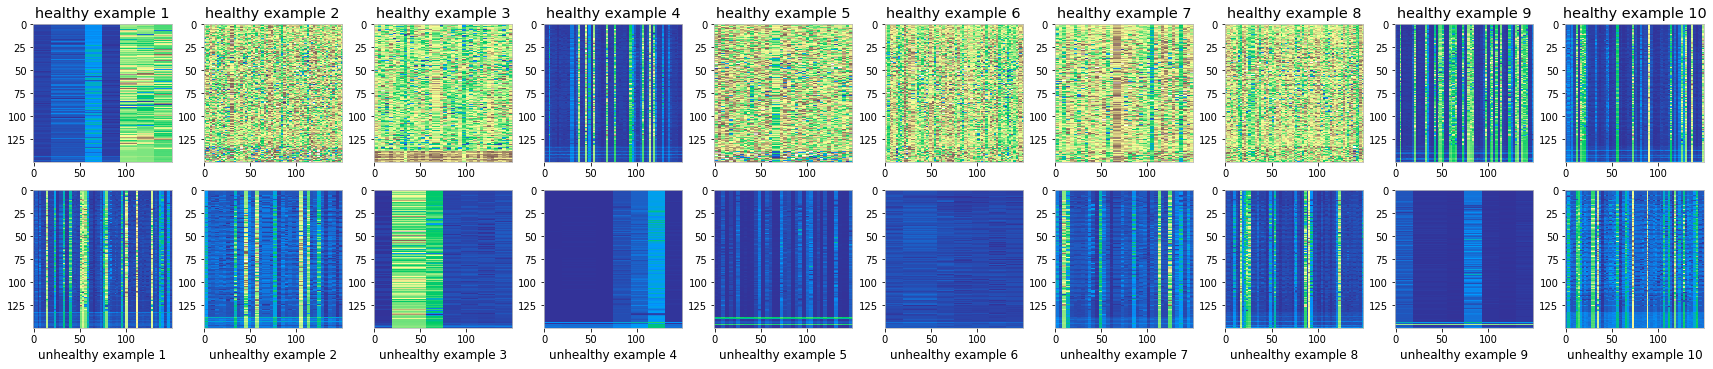

In [119]:
fig = plt.figure(figsize=(30, 30))

for i, img_path in enumerate(healthy_im):
    ax = fig.add_subplot(10,10,i+1)
    img = image.load_img(healthy+img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    plt.grid(False)
    ax.set_title(f'healthy example {i+1}')
    ax.imshow(img_tensor[0],  cmap='terrain_r')

for i, img_path in enumerate(unhealthy_im):
    ax = fig.add_subplot(10,10,i+11)
    img = image.load_img(unhealthy+img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    plt.grid(False)
    ax.set_xlabel(f'unhealthy example {i+1}')
    ax.imshow(img_tensor[0],  cmap='terrain_r')

In [114]:
from tensorflow.keras import models
layer_outputs = [layer.output for layer in m.layers[:4]]
activation_model = models.Model(inputs=m.input, outputs=layer_outputs)

In [115]:
activations = activation_model.predict(img_tensor)

In [116]:
activations[0].shape

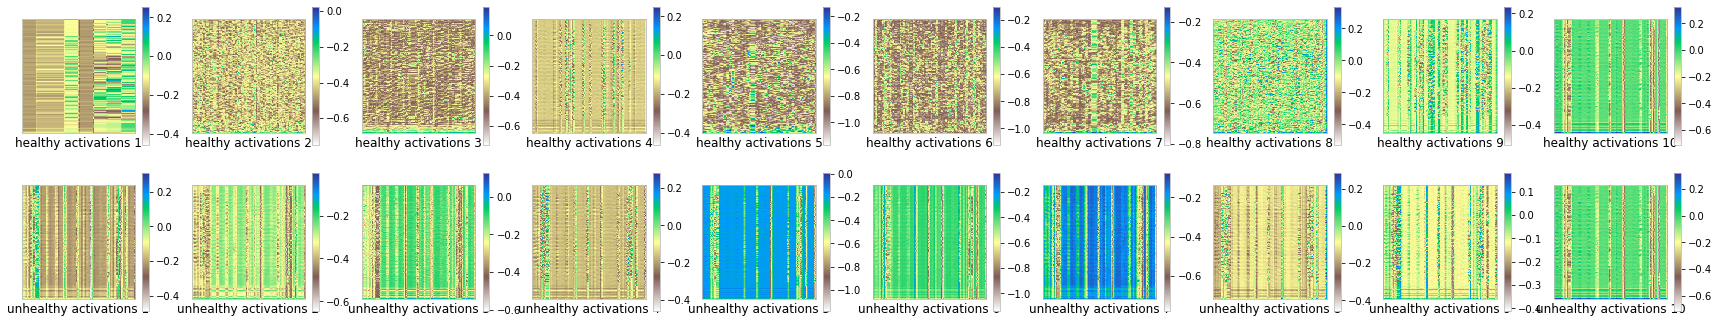

In [130]:
fig = plt.figure(figsize=(30, 30))

for i, img_path in enumerate(healthy_im):
    ax = fig.add_subplot(10,10,i+1)
    img = image.load_img(healthy+img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    activations = activation_model.predict(img_tensor)
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
    ax.set_xlabel(f'healthy activations {i+1}')
    plt.colorbar(ax.imshow(activations[0][0,:,:, i],  cmap='terrain_r'))

for i, img_path in enumerate(unhealthy_im):
    ax = fig.add_subplot(10,10,i+11)
    img = image.load_img(unhealthy+img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
    ax.set_xlabel(f'unhealthy activations {i+1}')
    plt.colorbar(ax.imshow(activations[0][0,:,:, i],  cmap='terrain_r'))

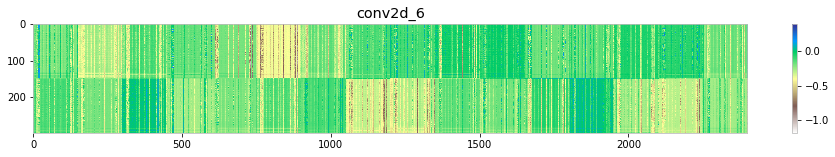

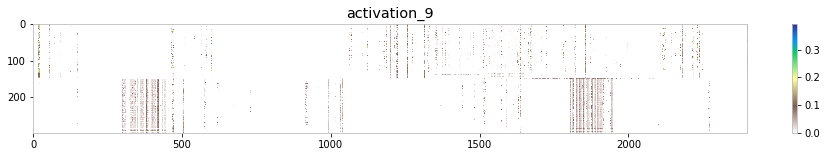

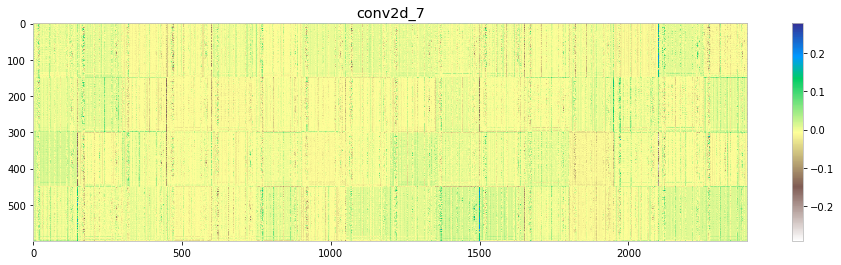

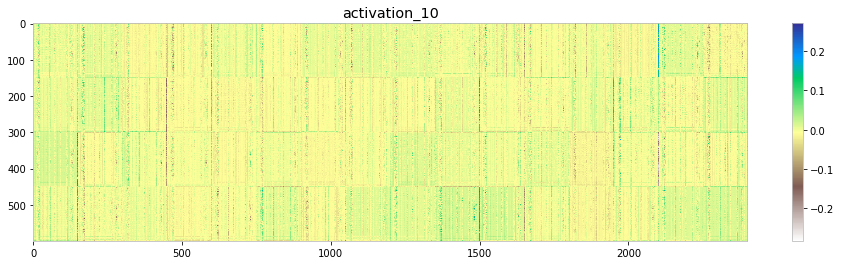

In [118]:
layer_names = []                                                          
for layer in m.layers[:7]:                                            
    layer_names.append(layer.name)                                        

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):        
    n_features = layer_activation.shape[-1]                               

    size = layer_activation.shape[1]                                      

    n_cols = n_features // images_per_row                                 
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):                                             
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,
                                              :,
                                             col * images_per_row + row]
            #channel_image -= channel_image.mean()                         
            #channel_image /= channel_image.std()
            #channel_image *= 64
            #channel_image += 128
            #channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,                   
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.colorbar(plt.imshow(display_grid, aspect='auto', cmap='terrain_r'))

In [132]:
from keras import backend as K

layer_name ='conv2d_6'
filter_index = 0

layer_output = m.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [133]:
grads =K.gradients(loss, m.input)[0]

In [134]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [135]:
iterate = K.function([m.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [136]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.                                                           
for i in range(40):                                                  
    loss_value, grads_value = iterate([input_img_data])             

    input_img_data += grads_value * step                            

In [137]:
def deprocess_image(x):
    x -= x.mean()                                
    x /= (x.std() + 1e-5)                        
    x *= 0.1                                     

    x += 0.5                                     
    x = np.clip(x, 0, 1)                         

    x *= 255                                     
    x = np.clip(x, 0, 255).astype('uint8')       
    return x                                     

In [138]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = m.get_layer(layer_name).output                     
    loss = K.mean(layer_output[:, :, :, filter_index])                    

    grads = K.gradients(loss, m.input)[0]                             

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)                     

    iterate = K.function([m.input], [loss, grads])                    

    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.     

    step = 1.                                                             
    for i in range(40):                                                   
        loss_value, grads_value = iterate([input_img_data])               
        input_img_data += grads_value * step                              

    img = input_img_data[0]
    return deprocess_image(img)

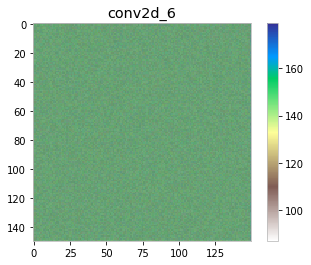

In [151]:
plt.grid(False)
plt.title('conv2d_6')
plt.colorbar(plt.imshow(generate_pattern('conv2d_6', 0), cmap='terrain_r'));

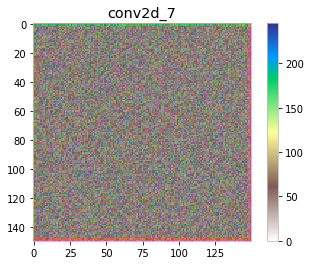

In [152]:
plt.grid(False)
plt.title('conv2d_7')
plt.colorbar(plt.imshow(generate_pattern('conv2d_7', 0), cmap='terrain_r'));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


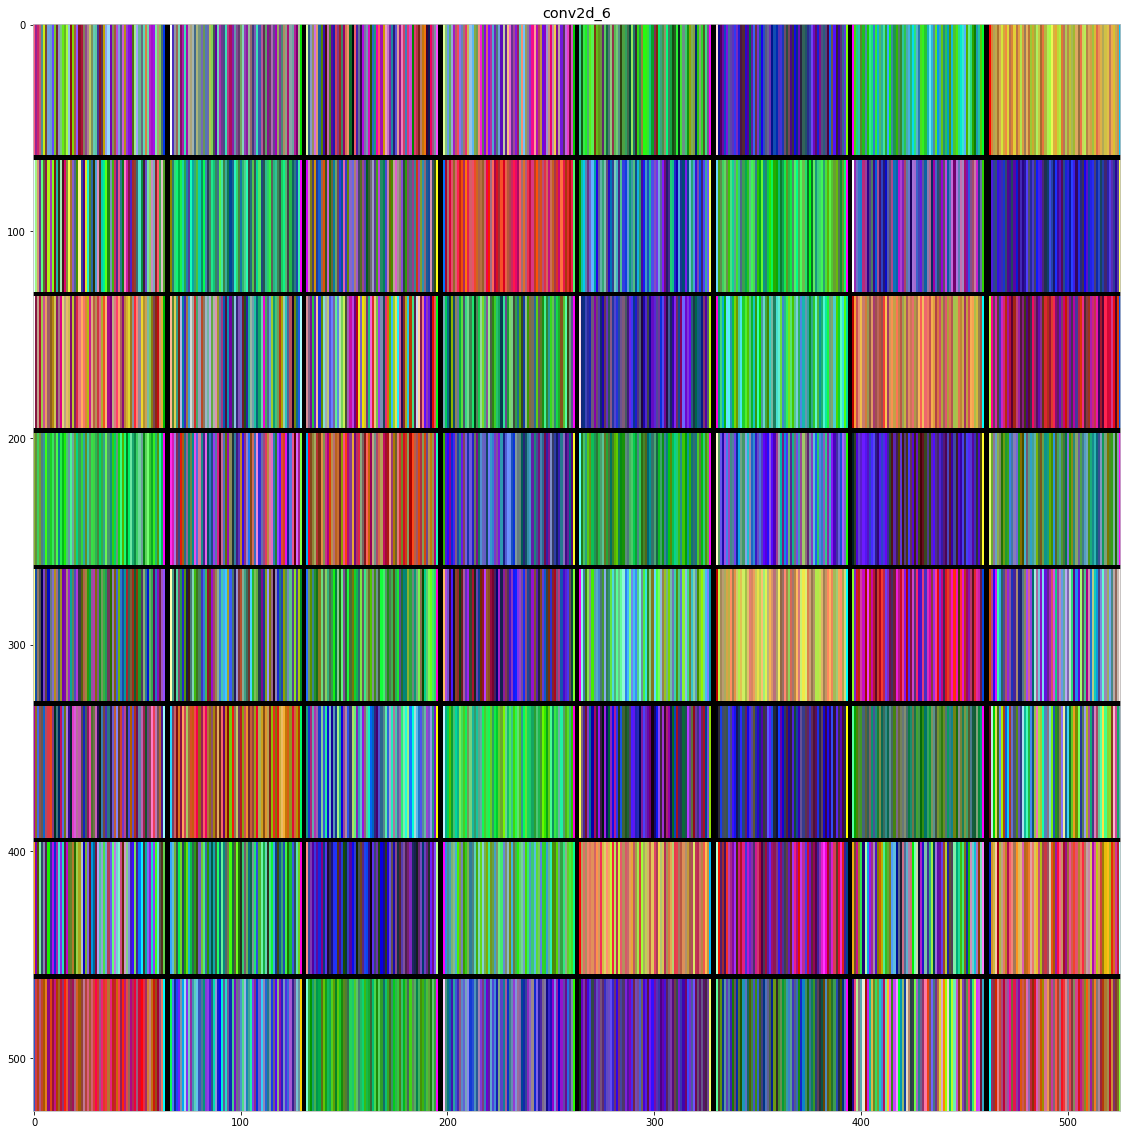

In [154]:
layer_name = 'conv2d_6'
size = 64
margin = 2

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))      
t = []
for i in range(8):                  
    for j in range(8):                                                     
        filter_img = generate_pattern(layer_name, i + (j * 2), size=size)  
        horizontal_start = i * size + i * margin                           
        horizontal_end = horizontal_start + size                           
        vertical_start = j * size + j * margin              
        vertical_end = vertical_start + size                
        results[horizontal_start: horizontal_end,                          
                vertical_start: vertical_end, :] = minmax_scale(filter_img[0])          

plt.figure(figsize=(20, 20))                                               
plt.grid(False)
plt.title(layer_name)
plt.imshow(results);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


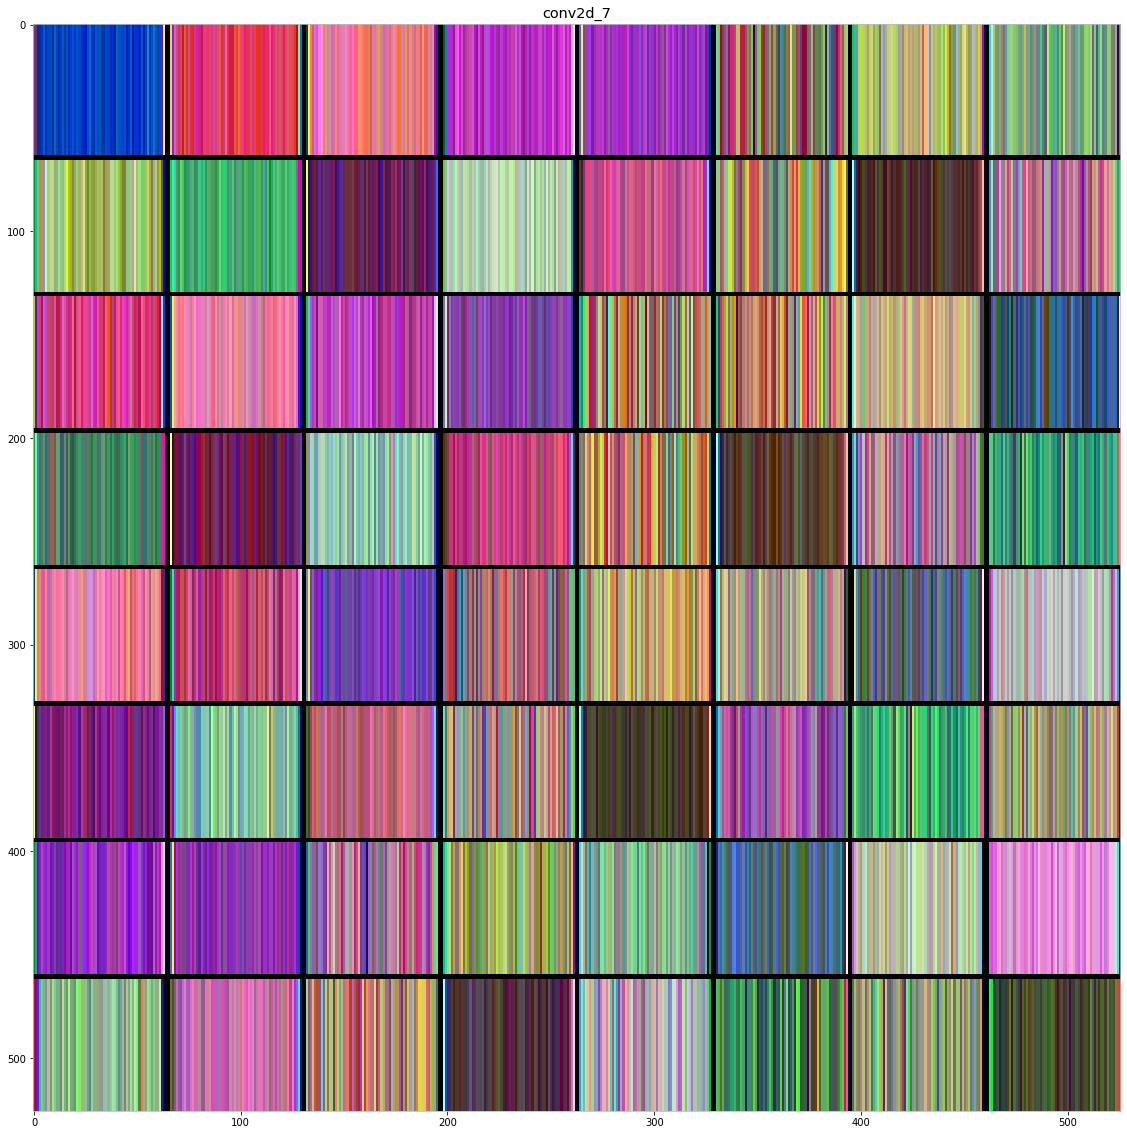

In [155]:
layer_name = 'conv2d_7'
size = 64
margin = 2

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))      
t = []
for i in range(8):                  
    for j in range(8):                                                     
        filter_img = generate_pattern(layer_name, i + (j * 2), size=size)  
        horizontal_start = i * size + i * margin                           
        horizontal_end = horizontal_start + size                           
        vertical_start = j * size + j * margin              
        vertical_end = vertical_start + size                
        results[horizontal_start: horizontal_end,                          
                vertical_start: vertical_end, :] = minmax_scale(filter_img[0])          

plt.figure(figsize=(20, 20))                                               
plt.grid(False)
plt.title(layer_name)
plt.imshow(results);

NameError: name 'm' is not defined

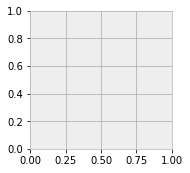

In [13]:
fig = plt.figure(figsize=(30, 30))
heatmaps = []
for i, img_path in enumerate(healthy_im):
    ax = fig.add_subplot(10,10,i+1)
    img = image.load_img(healthy+img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    with tf.device('/CPU:0'):
        pred = m.predict(x)
    _output = m.output[:,1]                          

    last_conv_layer = m.get_layer('conv2d_7')                         

    grads = K.gradients(_output, last_conv_layer.output)[0]   

    pooled_grads = K.mean(grads, axis=(0, 1, 2))                              

    iterate = K.function([m.input],
                     [pooled_grads, last_conv_layer.output[0]])           
    with tf.device('/CPU:0'):
        pooled_grads_value, conv_layer_output_value = iterate([x])                

    for i in range(32):                                                      
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]             

    heatmap = np.mean(conv_layer_output_value, axis=-1)  
    
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
    ax.set_xlabel(f'healthy heatmap {i+1}')
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmaps.append(heatmap)
    plt.colorbar(ax.matshow(heatmap,  cmap='terrain_r'))

for i, img_path in enumerate(unhealthy_im):
    ax = fig.add_subplot(10,10,i+11)
    img = image.load_img(unhealthy+img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    with tf.device('/CPU:0'):
        pred = m.predict(x)
    _output = m.output[:,1]                          

    last_conv_layer = m.get_layer('conv2d_7')                         

    grads = K.gradients(_output, last_conv_layer.output)[0]   

    pooled_grads = K.mean(grads, axis=(0, 1, 2))                              

    iterate = K.function([m.input],
                     [pooled_grads, last_conv_layer.output[0]])           
    with tf.device('/CPU:0'):
        pooled_grads_value, conv_layer_output_value = iterate([x])                

    for ii in range(32):                                                      
        conv_layer_output_value[:, :, ii] *= pooled_grads_value[ii]             

    heatmap = np.mean(conv_layer_output_value, axis=-1)  
    
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
    ax.set_xlabel(f'unhealthy heatmap {i+1}')
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmaps.append(heatmap)
    plt.colorbar(ax.matshow(heatmap,  cmap='terrain_r'))


In [1]:
import cv2

img = cv2.imread(img_path)                                                 

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))                

heatmap = np.uint8(255 * heatmap)                                          

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)                     

superimposed_img = heatmap * 0.4 + img                                     

NameError: name 'img_path' is not defined

In [58]:
cv2.imwrite('HEATMAPOUT.jpg', superimposed_img)